# Day 8 Action Items, MNIST hand digit recognition with CNN
## Today I'll implement a model to recognize written hand digits using the famous MNIST data set.
## I used kaggle's version due to internet limitations and it'd be better for me to work on kaggle notebooks.

## importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import warnings
from keras.utils.np_utils import to_categorical 
# filter warnings
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [57]:
s= pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [58]:
s.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


### reading and inspecting data set

In [2]:
train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test =pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
train.shape

(42000, 785)

In [4]:
test.shape

(28000, 784)

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### As read in the data info section, each image is 28x28 pixels = 784 pixel and Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

### Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

### The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

## split the label and values and visualize data set.

In [7]:
y_train = train['label']
x_train = train.drop(labels = ['label'], axis=1)

In [8]:
x_train.shape

(42000, 784)

In [9]:
y_train.shape

(42000,)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

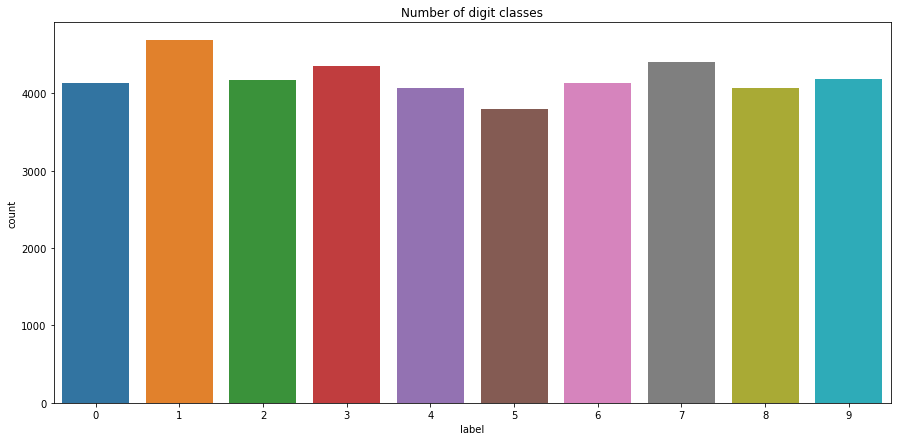

In [10]:
plt.figure(figsize=(15,7))
g = sns.countplot(y_train)
plt.title("Number of digit classes")
y_train.value_counts()

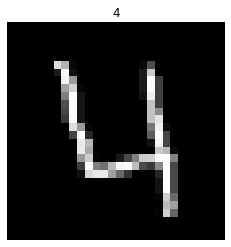

In [11]:
img = np.array(x_train.iloc[3])
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

1. In order for a CNN to work faster we need to normalize the inputs and perform grayscale conversion to reduce differences in light, colors.
2. we also need to reshape the inputs and encode the labels with one hote encoded vectors 

In [12]:
# normalization
x_train = x_train / 255.0
test = test /255.0

In [13]:
x_train.shape

(42000, 784)

In [14]:
test.shape

(28000, 784)

In [15]:
x_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# reshaping
x_train =x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [17]:
x_train.shape

(42000, 28, 28, 1)

In [18]:
test.shape

(28000, 28, 28, 1)

In [19]:
# one hot encoding the label
y_train = to_categorical(y_train,num_classes = 10 )

In [20]:
y_train[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Split data into train,test for initial evaluation

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)

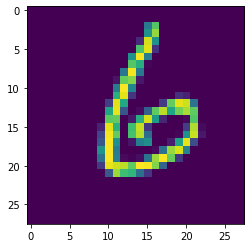

In [22]:
plt.imshow(X_train[2][:,:,0]);

### creating model and training

In [23]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected layers
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0

In [25]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [26]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### data augmentation to increase number of training samples, increase generelaization and avoid overfitting.

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### Model training

In [28]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=256), epochs = 25, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // 256)

Epoch 1/25
147/147 [==============================] - 18s 118ms/step - loss: 1.5580 - accuracy: 0.4611 - val_loss: 0.2359 - val_accuracy: 0.9364
Epoch 2/25
147/147 [==============================] - 17s 115ms/step - loss: 0.4973 - accuracy: 0.8395 - val_loss: 0.1324 - val_accuracy: 0.9660
Epoch 3/25
147/147 [==============================] - 17s 114ms/step - loss: 0.3371 - accuracy: 0.8959 - val_loss: 0.0995 - val_accuracy: 0.9712
Epoch 4/25
147/147 [==============================] - 17s 112ms/step - loss: 0.2859 - accuracy: 0.9097 - val_loss: 0.0875 - val_accuracy: 0.9743
Epoch 5/25
147/147 [==============================] - 17s 114ms/step - loss: 0.2465 - accuracy: 0.9239 - val_loss: 0.0737 - val_accuracy: 0.9783
Epoch 6/25
147/147 [==============================] - 16s 112ms/step - loss: 0.2182 - accuracy: 0.9321 - val_loss: 0.0705 - val_accuracy: 0.9798
Epoch 7/25
147/147 [==============================] - 17s 115ms/step - loss: 0.2051 - accuracy: 0.9352 - val_loss: 0.0634 - val_ac

## model performance evaluation

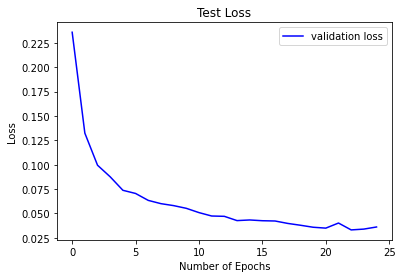

In [29]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

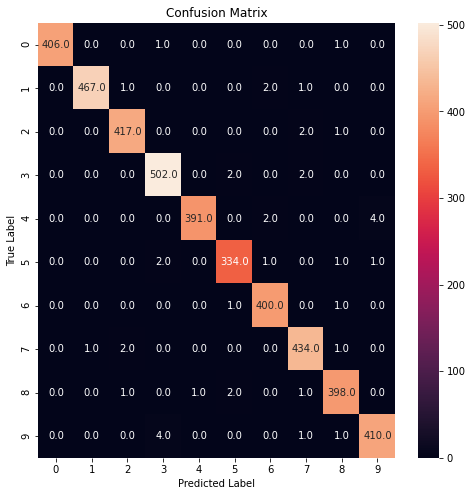

In [30]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix");

In [31]:
test.shape

(28000, 28, 28, 1)

In [32]:
model.evaluate(X_val,Y_val)

132/132 [==============================] - 1s 6ms/step - loss: 0.0361 - accuracy: 0.9902


[0.03608451038599014, 0.9902380704879761]

In [33]:
y_pred = model.predict(test)

In [34]:
y_pred.shape

(28000, 10)

In [38]:
max(y_pred[0])

0.999956

In [35]:
tests =pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [45]:
tests.shape

(28000, 784)

## Make submission

### this function reverses the One hot encoding

In [87]:
def reverse_hoc(df):
    y=[]
    for i in range(28000):
        y.append(int(df[i].argmax()))
    return y     

In [88]:
ys=reverse_hoc(y_pred)

In [90]:
len(ys)

28000

In [91]:
final= pd.DataFrame({'ImageId':range(1,28001),'Label':ys})

In [92]:
final.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [93]:
final.to_csv('sub2.csv', index=False)  

## And that's it for today's action Item.